 # Import Libraries, Data Loading, and Initial Inspection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


# Load and inspect the dataset
movie_data = pd.read_csv(r'C:\Users\asmaj\Downloads\DATA SCIENCE\IMDb Movies India.csv', encoding='ISO-8859-1')

# Display the first few rows and check for missing values
print(movie_data.head())
print(movie_data.info())
print(movie_data.isnull().sum())


                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  
3  Siddhant Kapoor  
4    

# Handle Missing Values and Convert Columns

In [ ]:
# Drop rows with missing ratings
movie_data = movie_data.dropna(subset=['Rating'])

# Fill remaining missing values with 'Unknown' for categorical and 0 for numeric fields
movie_data = movie_data.fillna({'Director': 'Unknown', 'Actor 1': 'Unknown',
                                'Actor 2': 'Unknown', 'Actor 3': 'Unknown'})
movie_data['Duration'] = movie_data['Duration'].str.extract('(\d+)').astype(float).fillna(0)
movie_data['Year'] = movie_data['Year'].str.extract('(\d+)').astype(float).fillna(0)

# Expand "Genre" into multiple binary columns
genres = movie_data['Genre'].str.get_dummies(sep=', ')
movie_data = pd.concat([movie_data, genres], axis=1)


# Encode Categorical Variables

In [ ]:
# Set up the one-hot encoder for the categorical columns
categorical_features = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
numerical_features = ['Year', 'Duration'] + list(genres.columns)

# Use ColumnTransformer to apply one-hot encoding to categorical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


# Feature Scaling and Interaction Terms


In [ ]:
X = movie_data.drop(['Rating', 'Genre'], axis=1)  # Drop Genre as it's split into multiple columns
y = movie_data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define Features and Target Variables, Split Data

In [ ]:
# Create a pipeline that includes preprocessing and the Random Forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter tuning for RandomForestRegressor
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Duration',
                                                                          'Action',
                                                                          'Adventure',
                                                                          'Animation',
                                                                          'Biography',
                                                                          'Comedy',
                                                                          'Crime',
                                                                          'Documentary',
                                                                          'Drama',
                                                                          'Family',
                                                                          'Fantasy',
                                                                          'History',
                                                                          'Horror',
                                                                          'Music',
                                                                          'Musical',
                                                                          'Mystery',
                                                                          'News',
                                                                          'Romance',
                                                                          'Sci-Fi',
                                                                          'Sport',
                                                                          'Thriller',
                                                                          'War',
                                                                          'Western']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Director',
                                                                          'Actor '
                                                                          '1',
                                                                          'Actor '
                                                                          '2',
                                                                          'Actor '
                                                                          '3'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, None],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='r2')

# Model Definition and Training


In [ ]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions and evaluation on the test set
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Mean Squared Error: 1.3345966010758954
R-squared Score: 0.2821450182126999


In [ ]:
# Extract feature importances from the best Random Forest model
feature_importances = best_model.named_steps['model'].feature_importances_
feature_names = numerical_features + list(grid_search.best_estimator_.named_steps['preprocessor']
                                          .transformers_[1][1].get_feature_names_out(categorical_features))
importances = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# Display the most important features
print("Top 10 Important Features:\n", importances.head(10))


Top 10 Important Features:
 Year                  0.230621
Duration              0.087315
Documentary           0.054488
Drama                 0.038491
Action                0.025761
Horror                0.021525
Romance               0.013294
Comedy                0.010583
Thriller              0.005177
Actor 1_Aamir Khan    0.005124
dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display metrics
print("Training Set Metrics:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R-squared: {train_r2}")

print("\nTest Set Metrics:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R-squared: {test_r2}")


Training Set Metrics:
Mean Squared Error: 0.8127587199381675
Mean Absolute Error: 0.7345756955459684
R-squared: 0.5769057431748034

Test Set Metrics:
Mean Squared Error: 1.3345966010758954
Mean Absolute Error: 0.8925277746170986
R-squared: 0.2821450182126999


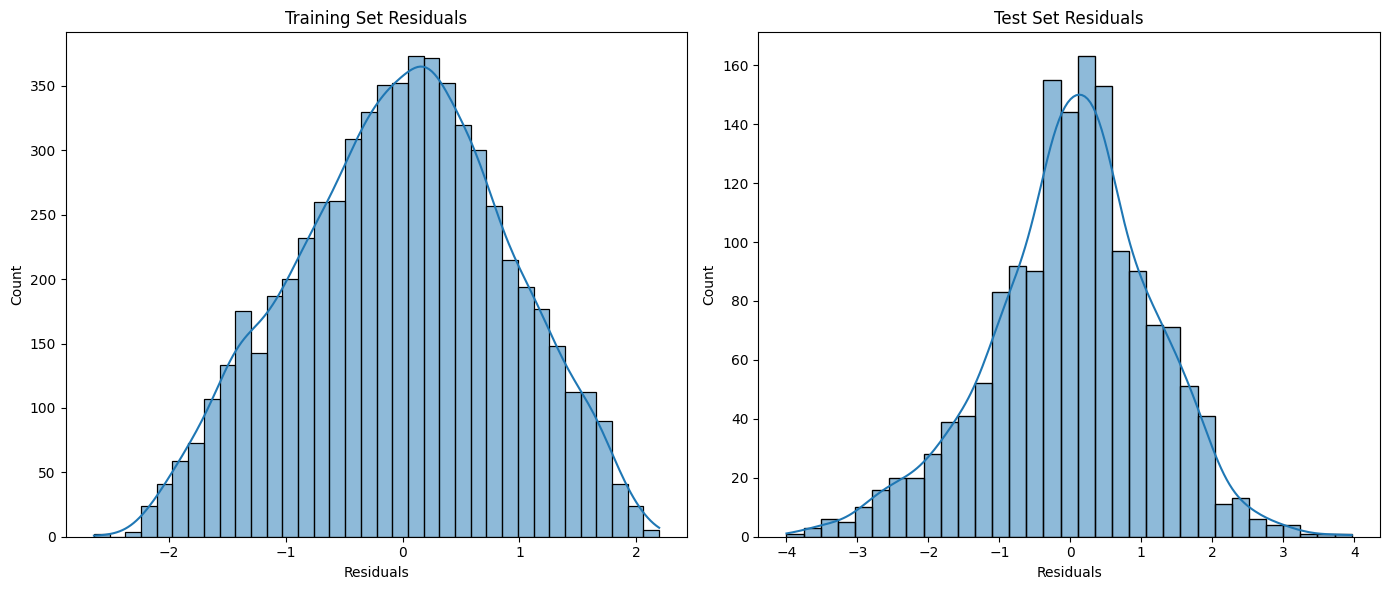

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot residuals for training and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals")
plt.xlabel("Residuals")

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.title("Test Set Residuals")
plt.xlabel("Residuals")

plt.tight_layout()
plt.show()


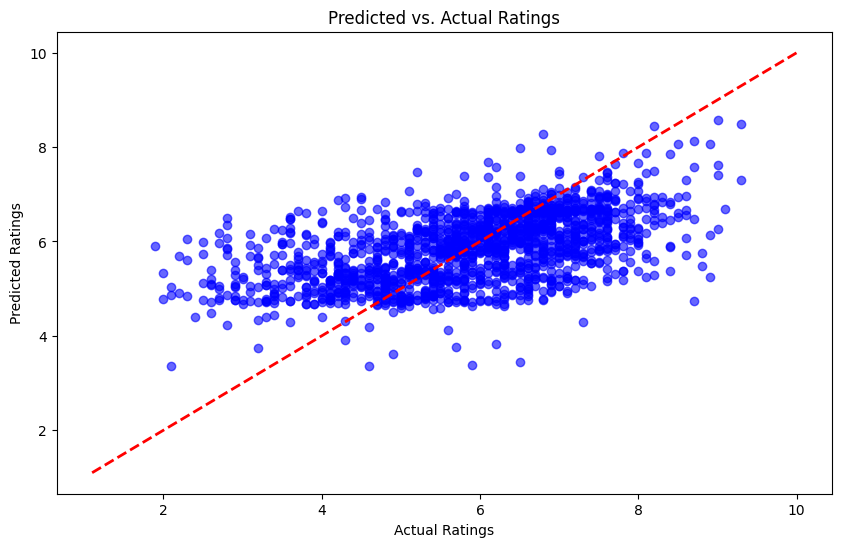

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line for reference
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs. Actual Ratings")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validate with R-squared as the scoring metric
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-Validation R-squared scores:", cv_scores)
print("Average R-squared score from Cross-Validation:", np.mean(cv_scores))


Cross-Validation R-squared scores: [0.28425828 0.24485704 0.26831421 0.26574957 0.24379063]
Average R-squared score from Cross-Validation: 0.261393946238625
